In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import (
    LinearRegression, HuberRegressor, SGDRegressor,
    Lasso, Ridge, ElasticNet
)

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

# Set random seed for reproducibility
np.random.seed(42)
# Display settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [26]:
# Load the dataset
file_path = os.path.join(os.getcwd(),"data", "dynamic_pricing.csv")  # Replace with the correct file path
data = pd.read_csv(file_path)

# Initial data overview
print("Shape of the dataset:", data.shape)
print("\nFirst 5 rows of the dataset:")
print(data.head())

Shape of the dataset: (1000, 10)

First 5 rows of the dataset:
   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium                      90   
1         Evening      Economy                     

In [27]:
# Analyze categorical features
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nCategorical columns:", list(categorical_columns))


Categorical columns: ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type']


In [28]:
# One-hot encoding for all categorical variables
df = data.copy()
data_one_hot = pd.get_dummies(data, columns=categorical_columns, drop_first=True)

print("Dataset after One-Hot Encoding:")
print(data_one_hot.head())

Dataset after One-Hot Encoding:
   Number_of_Riders  Number_of_Drivers  Number_of_Past_Rides  Average_Ratings  \
0                90                 45                    13             4.47   
1                58                 39                    72             4.06   
2                42                 31                     0             3.99   
3                89                 28                    67             4.31   
4                78                 22                    74             3.77   

   Expected_Ride_Duration  Historical_Cost_of_Ride  \
0                      90               284.257273   
1                      43               173.874753   
2                      76               329.795469   
3                     134               470.201232   
4                     149               579.681422   

   Location_Category_Suburban  Location_Category_Urban  \
0                       False                     True   
1                        True           

In [29]:
new_categorical_columns = [col for col in data_one_hot.columns if data_one_hot[col].dtype == 'bool']

print("Categorical columns to convert:", new_categorical_columns)
# Convert only the categorical columns (boolean) to integers
data_one_hot[new_categorical_columns] = data_one_hot[new_categorical_columns].astype(int)
# Verify data types of the columns
print(data_one_hot.dtypes)

# Ensure values are 0 and 1
for col in new_categorical_columns:
    print(f"{col}: {data_one_hot[col].unique()}")

Categorical columns to convert: ['Location_Category_Suburban', 'Location_Category_Urban', 'Customer_Loyalty_Status_Regular', 'Customer_Loyalty_Status_Silver', 'Time_of_Booking_Evening', 'Time_of_Booking_Morning', 'Time_of_Booking_Night', 'Vehicle_Type_Premium']
Number_of_Riders                     int64
Number_of_Drivers                    int64
Number_of_Past_Rides                 int64
Average_Ratings                    float64
Expected_Ride_Duration               int64
Historical_Cost_of_Ride            float64
Location_Category_Suburban           int64
Location_Category_Urban              int64
Customer_Loyalty_Status_Regular      int64
Customer_Loyalty_Status_Silver       int64
Time_of_Booking_Evening              int64
Time_of_Booking_Morning              int64
Time_of_Booking_Night                int64
Vehicle_Type_Premium                 int64
dtype: object
Location_Category_Suburban: [0 1]
Location_Category_Urban: [1 0]
Customer_Loyalty_Status_Regular: [0 1]
Customer_Loyalty_S

In [30]:
base_processed_df = data_one_hot.copy()
# Generate a synthetic regression dataset
X = data_one_hot.drop('Historical_Cost_of_Ride', axis=1)  # Exclude the target variable
y = data_one_hot['Historical_Cost_of_Ride']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
#"OrthogonalMatchingPursuit": (OrthogonalMatchingPursuit(fit_intercept=False), {"n_nonzero_coefs": [5, 6, 7, 8, 9, 10, 15]}),
# Define models and their hyperparameter grids
models_and_params = {
    "LinearRegression": (LinearRegression(fit_intercept=False), {}),
    "HuberRegressor": (HuberRegressor(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "epsilon": [1.35, 1.5, 1.75]}),
    "SGDRegressor": (SGDRegressor(fit_intercept=False, penalty=None, max_iter=1000, tol=1e-3),
                      {"alpha": np.logspace(-4, -1, 4), "learning_rate": ["constant", "optimal", "invscaling"], "eta0": [0.01, 0.1, 1.0]}),

    "Lasso": (Lasso(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4)}),
    "Ridge": (Ridge(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "solver": ["auto", "svd", "cholesky"]}),
    "ElasticNet": (ElasticNet(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4), "l1_ratio": [0.1, 0.5, 0.9]})
}

# Evaluate models
results = []
for name, (model, params) in models_and_params.items():
    try:
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get best model and its performance
        best_model = grid_search.best_estimator_
        best_score = -grid_search.best_score_  # Convert negative MSE to positive
        best_params = grid_search.best_params_

        # Test data evaluation
        y_test_pred = best_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Fit the best model to retrieve coefficients
        best_model.fit(X_train, y_train)
        coefficients = best_model.coef_

        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Mean_CV_MAE": best_score,
            "Test_MAE": test_mse,
            "Test_R2": test_r2,
            "Coefficients": coefficients
        })
    except Exception as e:
        print(f"Model {name} failed with error: {e}")


# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Sort by performance (Mean CV MSE)
results_df = results_df.sort_values(by="Test_MAE")

# Add coefficients to the results DataFrame
results_df["Coefficients"] = results_df["Coefficients"].apply(lambda coef: np.array2string(coef, precision=3, separator=","))

# Display results
print("Model Performance (Train and Test):")
print(results_df[["Model", "Mean_CV_MAE", "Test_MAE", "Test_R2"]])

# Display Coefficients of the Top Model
top_model_row = results_df.iloc[0]  # Get the best-performing model
print("\nTop Model Details:")
print(f"Model: {top_model_row['Model']}")
print(f"Mean CV MAE: {top_model_row['Mean_CV_MAE']}")
print(f"Test MAE: {top_model_row['Test_MAE']}")
print(f"Test R2: {top_model_row['Test_R2']}")
print(f"Best Params: {top_model_row['Best_Params']}")
print(f"Coefficients:\n{top_model_row['Coefficients']}")

# Save the results as CSV (optional)
#results_df.to_csv("model_results.csv", index=False)



Training set shape: (800, 13) (800,)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Model Performance (Train and Test):
              Model   Mean_CV_MAE      Test_MAE       Test_R2
0  LinearRegression  5.167013e+01  4.541915e+03  8.754302e-01
4             Ridge  5.162377e+01  4.557485e+03  8.750032e-01
3             Lasso  5.135838e+01  4.577798e+03  8.744460e-01
1    HuberRegressor  5.167943e+01  4.581335e+03  8.743490e-01
5        ElasticNet  5.162167e+01  4.604310e+03  8.737189e-01
2      SGDRegressor  6.610797e+11  7.210049e+23 -1.977479e+19

Top Model Details:
Model: LinearRegression
Mean CV MAE: 51.67012822574223
Test MAE: 4541.915277106265
Test R2: 0.875430190431375
Best Params: {}
Coefficients:
[-8.810e-02, 4.940e-01,-3.055e-03,-7.090e-01, 3.517e+00,-4.007e+00,
 -4.807e+00, 2.784e+00, 4.518e+00,-6.743e+00,-9.346e-01,-4.143e+00,
  4.195e+01]


In [31]:
unit_duration_charges = base_processed_df["Historical_Cost_of_Ride"] / base_processed_df["Expected_Ride_Duration"]
average_price_per_minute = unit_duration_charges.mean()
print("Average price per minute: ", average_price_per_minute)

Average price per minute:  3.8900681652735383


In [32]:
# Define the response and feature
y = df["Historical_Cost_of_Ride"]
X = df["Expected_Ride_Duration"].values.reshape(-1, 1)

# Train the model
from sklearn.linear_model import HuberRegressor
model = HuberRegressor(fit_intercept=True)
model.fit(X, y)

# Extract coefficients and intercept
coefficient = model.coef_[0]  # Since there is only one feature
intercept = model.intercept_

# Construct the equation
feature_name = "Expected_Ride_Duration"  # Name of the feature
equation = f"y = {coefficient:.3f} * {feature_name} + {intercept:.3f}"

# Print the model equation
print("Model Equation:", equation)

Model Equation: y = 3.499 * Expected_Ride_Duration + 23.225


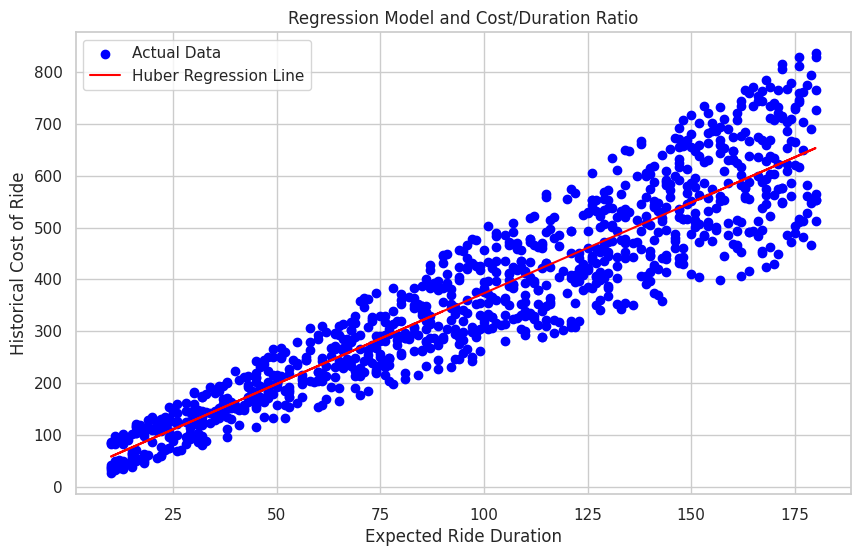

In [33]:
# Calculate the ratio for visualization
ratio = df["Historical_Cost_of_Ride"] / df["Expected_Ride_Duration"]

# Scatter plot of data points
plt.figure(figsize=(10, 6))
plt.scatter(df["Expected_Ride_Duration"], df["Historical_Cost_of_Ride"], color='blue', label='Actual Data')

# Plot the regression line
x_range = df["Expected_Ride_Duration"].values.reshape(-1, 1)
predicted_y = model.predict(x_range)
plt.plot(df["Expected_Ride_Duration"], predicted_y, color='red', label='Huber Regression Line')


# Add labels, title, and legend
plt.xlabel('Expected Ride Duration')
plt.ylabel('Historical Cost of Ride')
plt.title('Regression Model and Cost/Duration Ratio')
plt.legend()
plt.grid(True)
plt.show()

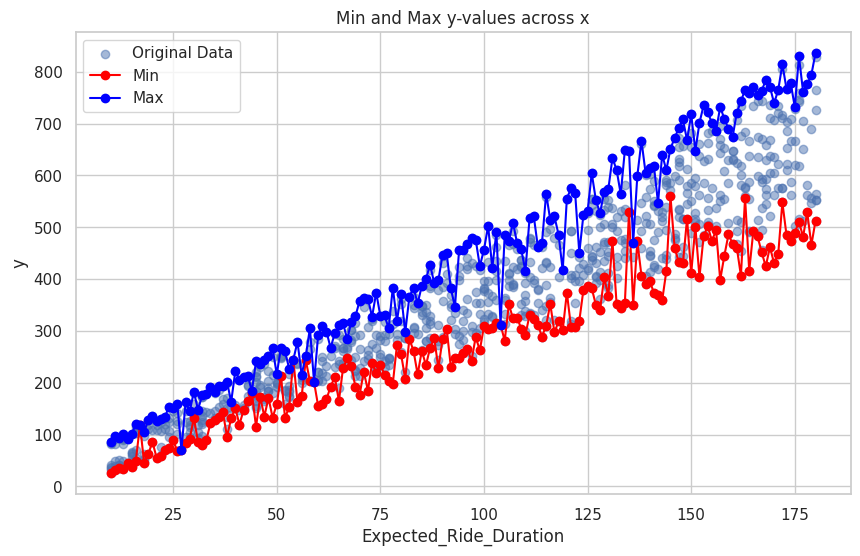

     Expected_Ride_Duration         min         max        mean
0                        10   25.993449   86.191180   53.204106
1                        11   31.565676   97.784506   65.353498
2                        12   36.000278   94.160918   52.473181
3                        13   34.574093  102.044730   77.653861
4                        14   44.525037   91.067777   60.503309
..                      ...         ...         ...         ...
166                     176  510.454375  829.534380  691.554948
167                     177  481.765879  761.016760  621.862146
168                     178  528.608073  775.791685  611.936467
169                     179  465.719058  794.323151  610.412247
170                     180  512.625110  836.116419  667.224282

[171 rows x 4 columns]


In [34]:
# Group by x and compute min and max
min_max = df.groupby('Expected_Ride_Duration')['Historical_Cost_of_Ride'].agg(['min', 'max' ,"mean"]).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df['Expected_Ride_Duration'], df['Historical_Cost_of_Ride'], alpha=0.5, label='Original Data')
plt.plot(min_max['Expected_Ride_Duration'], min_max['min'], color='red', marker='o', label='Min')
plt.plot(min_max['Expected_Ride_Duration'], min_max['max'], color='blue', marker='o', label='Max')
plt.xlabel('Expected_Ride_Duration')
plt.ylabel('y')
plt.legend()
plt.title('Min and Max y-values across x')
plt.show()

# Display min-max values
print(min_max)

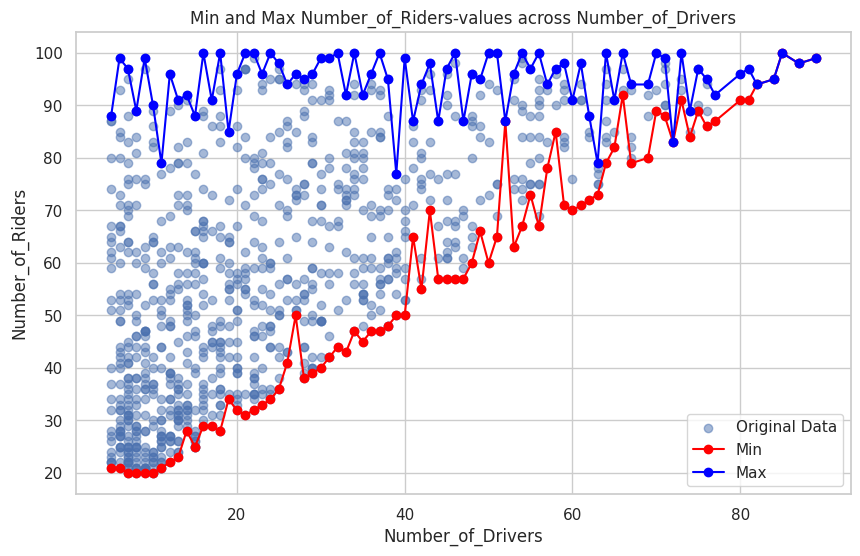

    Number_of_Drivers  min  max        mean
0                   5   21   88   48.307692
1                   6   21   99   46.536585
2                   7   20   97   42.730769
3                   8   20   89   41.236842
4                   9   20   99   42.000000
..                ...  ...  ...         ...
74                 82   94   94   94.000000
75                 84   95   95   95.000000
76                 85  100  100  100.000000
77                 87   98   98   98.000000
78                 89   99   99   99.000000

[79 rows x 4 columns]


In [35]:
# Group by x and compute min and max
min_max_drivers = df.groupby('Number_of_Drivers')['Number_of_Riders'].agg(['min', 'max' ,"mean"]).reset_index()

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(df['Number_of_Drivers'], df['Number_of_Riders'], alpha=0.5, label='Original Data')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['min'], color='red', marker='o', label='Min')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['max'], color='blue', marker='o', label='Max')
plt.xlabel('Number_of_Drivers')
plt.ylabel('Number_of_Riders')
plt.legend()
plt.title('Min and Max Number_of_Riders-values across Number_of_Drivers')
plt.show()

# Display min-max values
print(min_max_drivers)

Regression Equations:
Number_of_Riders_min = 1.01 * Number_of_Drivers + 11.41
Number_of_Riders_max = 0.02 * Number_of_Drivers + 94.95
Number_of_Riders_mean = 0.67 * Number_of_Drivers + 43.13


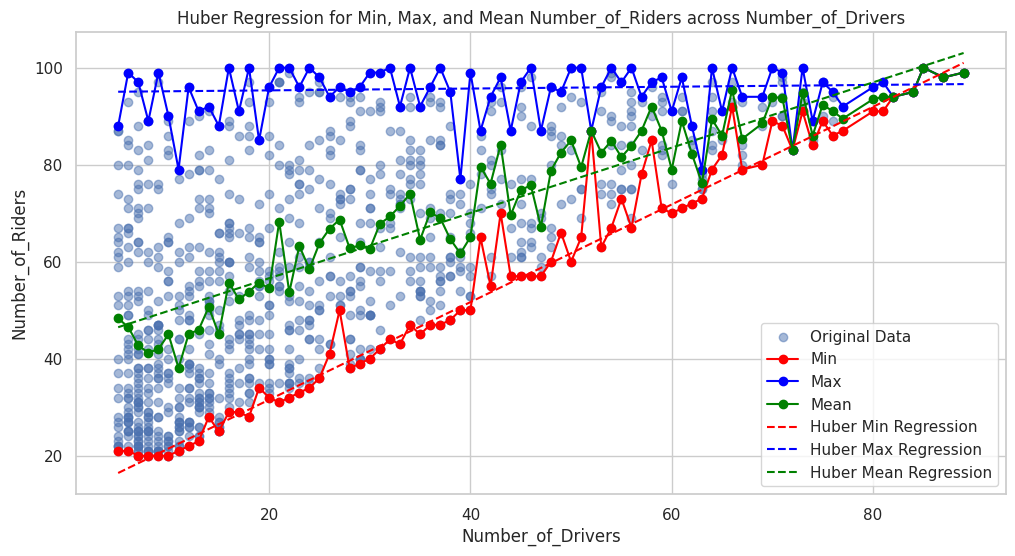

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [36]:
# Group data by 'Number_of_Drivers' and compute min, max, and mean
min_max_drivers = df.groupby('Number_of_Drivers')['Number_of_Riders'].agg(['min', 'max', 'mean']).reset_index()

# Initialize Huber Regressor for min, max, and mean
huber_min = HuberRegressor()
huber_max = HuberRegressor()
huber_mean = HuberRegressor()

# Prepare independent and dependent variables
X = min_max_drivers['Number_of_Drivers'].values.reshape(-1, 1)
y_min = min_max_drivers['min'].values
y_max = min_max_drivers['max'].values
y_mean = min_max_drivers['mean'].values

# Fit the models
huber_min.fit(X, y_min)
huber_max.fit(X, y_max)
huber_mean.fit(X, y_mean)

# Coefficients and intercepts
min_eq = f"Number_of_Riders_min = {huber_min.coef_[0]:.2f} * Number_of_Drivers + {huber_min.intercept_:.2f}"
max_eq = f"Number_of_Riders_max = {huber_max.coef_[0]:.2f} * Number_of_Drivers + {huber_max.intercept_:.2f}"
mean_eq = f"Number_of_Riders_mean = {huber_mean.coef_[0]:.2f} * Number_of_Drivers + {huber_mean.intercept_:.2f}"

print("Regression Equations:")
print(min_eq)
print(max_eq)
print(mean_eq)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(df['Number_of_Drivers'], df['Number_of_Riders'], alpha=0.5, label='Original Data')

# Plot min, max, and mean points
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['min'], color='red', marker='o', label='Min')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['max'], color='blue', marker='o', label='Max')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['mean'], color='green', marker='o', label='Mean')

# Add regression lines
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(x_range, huber_min.predict(x_range), color='red', linestyle='--', label='Huber Min Regression')
plt.plot(x_range, huber_max.predict(x_range), color='blue', linestyle='--', label='Huber Max Regression')
plt.plot(x_range, huber_mean.predict(x_range), color='green', linestyle='--', label='Huber Mean Regression')

# Plot settings
plt.xlabel('Number_of_Drivers')
plt.ylabel('Number_of_Riders')
plt.legend()
plt.title('Huber Regression for Min, Max, and Mean Number_of_Riders across Number_of_Drivers')
plt.grid(True)
plt.show()
print

In [37]:
# Define base surcharge and discount rates
base_surcharge = 0.2  # Base surcharge as 20%
base_discount = 0.1   # Base discount as 15%

# Example function to calculate surcharge or discount
def calculate_adjustment(num_drivers, actual_riders):
    # Predict values using Huber regressors
    predicted_min = huber_min.predict([[num_drivers]])[0]
    predicted_mean = huber_mean.predict([[num_drivers]])[0]
    predicted_max = huber_max.predict([[num_drivers]])[0]

    # Determine surcharge or discount
    if actual_riders > predicted_mean:  # Surcharge condition
        surcharge = ((actual_riders - predicted_mean) / (predicted_max - predicted_mean)) * base_surcharge
        return max(0, surcharge)  # Ensure non-negative value
    elif actual_riders < predicted_mean:  # Discount condition
        discount = ((predicted_mean - actual_riders) / (predicted_mean - predicted_min)) * base_discount
        return -max(0, discount)  # Negative value indicates a discount
    else:
        return 0  # No adjustment

# Apply adjustment logic for a sample dataset
adjustments = []
for _, row in df.iterrows():
    num_drivers = row['Number_of_Drivers']
    actual_riders = row['Number_of_Riders']
    adjustment = calculate_adjustment(num_drivers, actual_riders)
    adjustments.append(adjustment)

# Add adjustment column to the dataset
df['Adjustment_demand_supply'] = adjustments

# Display updated dataset
print(df[['Number_of_Drivers', 'Number_of_Riders', 'Adjustment_demand_supply']])

     Number_of_Drivers  Number_of_Riders  Adjustment_demand_supply
0                   45                90                  0.148198
1                   39                58                 -0.060825
2                   31                42                 -0.102889
3                   28                89                  0.161330
4                   22                78                  0.107207
..                 ...               ...                       ...
995                 23                33                 -0.106508
996                 29                84                  0.130001
997                  6                44                 -0.010663
998                 27                53                 -0.036559
999                 63                78                 -0.070377

[1000 rows x 3 columns]


-0.19832621895155603 0.38145496128236756


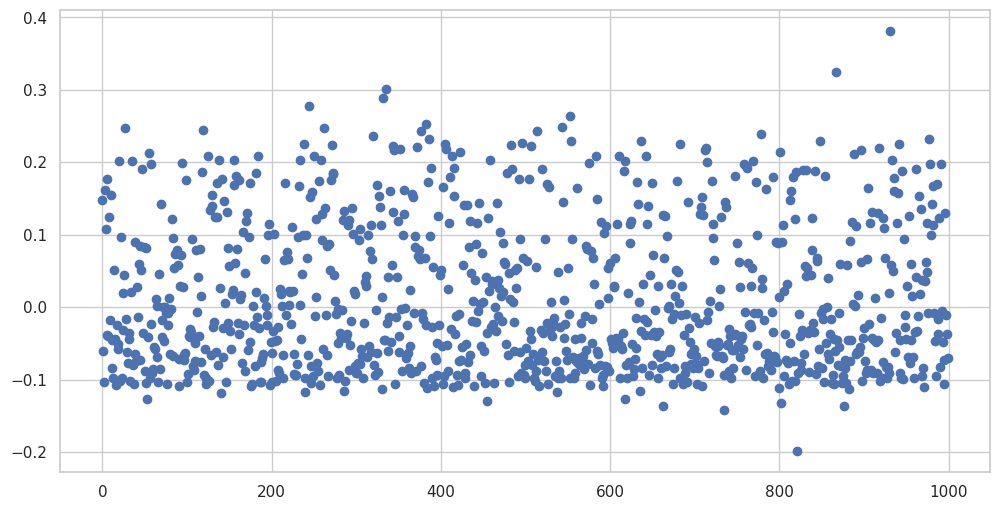

In [38]:
print(min(df['Adjustment_demand_supply']), max(df['Adjustment_demand_supply']))
plt.plot(df['Adjustment_demand_supply'], "o")

Regression Equations:
Number_of_Riders_min = 1.01 * Number_of_Drivers + 11.41
Number_of_Riders_max = 0.02 * Number_of_Drivers + 94.95
Number_of_Riders_mean = 0.67 * Number_of_Drivers + 43.13


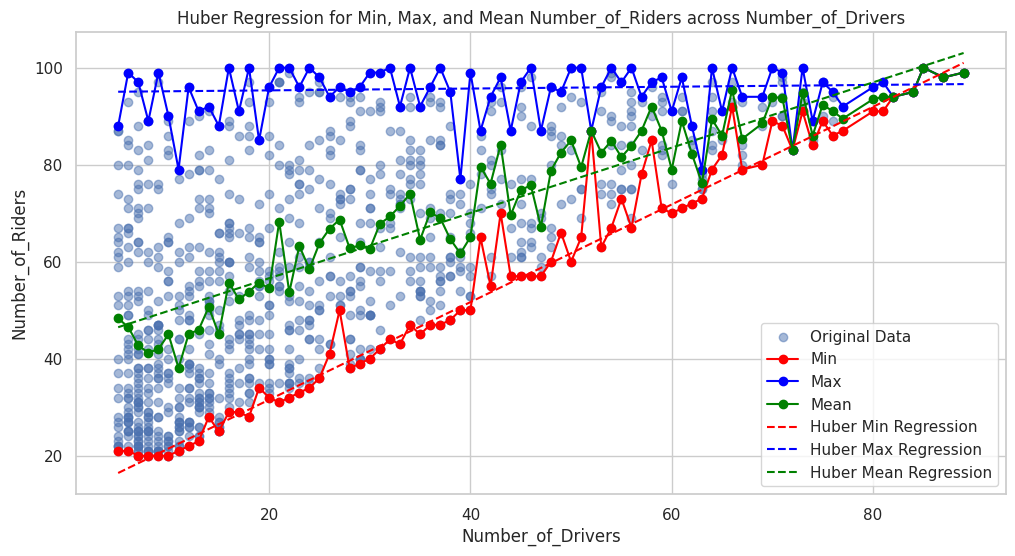

In [39]:
min_max_data = df.groupby('Historical_Cost_of_Ride')['Number_of_Drivers'].agg(['min', 'max', 'mean']).reset_index()
# Initialize Huber Regressor for min, max, and mean
huber_min = HuberRegressor()
huber_max = HuberRegressor()
huber_mean = HuberRegressor()

# Prepare independent and dependent variables
X = min_max_drivers['Number_of_Drivers'].values.reshape(-1, 1)
y_min = min_max_drivers['min'].values
y_max = min_max_drivers['max'].values
y_mean = min_max_drivers['mean'].values

# Fit the models
huber_min.fit(X, y_min)
huber_max.fit(X, y_max)
huber_mean.fit(X, y_mean)

# Coefficients and intercepts
min_eq = f"Number_of_Riders_min = {huber_min.coef_[0]:.2f} * Number_of_Drivers + {huber_min.intercept_:.2f}"
max_eq = f"Number_of_Riders_max = {huber_max.coef_[0]:.2f} * Number_of_Drivers + {huber_max.intercept_:.2f}"
mean_eq = f"Number_of_Riders_mean = {huber_mean.coef_[0]:.2f} * Number_of_Drivers + {huber_mean.intercept_:.2f}"

print("Regression Equations:")
print(min_eq)
print(max_eq)
print(mean_eq)

# Plot the results
plt.figure(figsize=(12, 6))
plt.scatter(df['Number_of_Drivers'], df['Number_of_Riders'], alpha=0.5, label='Original Data')

# Plot min, max, and mean points
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['min'], color='red', marker='o', label='Min')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['max'], color='blue', marker='o', label='Max')
plt.plot(min_max_drivers['Number_of_Drivers'], min_max_drivers['mean'], color='green', marker='o', label='Mean')

# Add regression lines
x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(x_range, huber_min.predict(x_range), color='red', linestyle='--', label='Huber Min Regression')
plt.plot(x_range, huber_max.predict(x_range), color='blue', linestyle='--', label='Huber Max Regression')
plt.plot(x_range, huber_mean.predict(x_range), color='green', linestyle='--', label='Huber Mean Regression')

# Plot settings
plt.xlabel('Number_of_Drivers')
plt.ylabel('Number_of_Riders')
plt.legend()
plt.title('Huber Regression for Min, Max, and Mean Number_of_Riders across Number_of_Drivers')
plt.grid(True)
plt.show()

In [40]:
df['Base_Price'] = df["Expected_Ride_Duration"]*average_price_per_minute  # Base price for all rides
# Define multipliers
location_multiplier = {'Urban': 1.0, 'Suburban': 1.2, 'Rural': 1.3}
time_multiplier = {'Morning': 1.0, 'Afternoon': 1.1, 'Evening': 1.2, 'Night': 1.5}
vehicle_multiplier = {'Economy': 1.0, 'Premium': 1.2}
loyalty_discount = {'Regular': 0.0, 'Silver': 0.1, 'Gold': 0.15}

# Calculate surcharges and rebates
df['Surcharge'] = df['Base_Price'] * df['Location_Category'].map(location_multiplier) * \
                    df['Time_of_Booking'].map(time_multiplier) * \
                    df['Vehicle_Type'].map(vehicle_multiplier) * 0.2  # Base surcharge rate (20%)

df['Rebate'] = df['Base_Price'] * df['Customer_Loyalty_Status'].map(loyalty_discount)

# Calculate final price
df['Final_Price'] = df['Base_Price'] + df['Surcharge'] - df['Rebate'] + df['Adjustment_demand_supply']

In [41]:
print((df['Final_Price']-df['Historical_Cost_of_Ride']).sum()/df.shape[0])
print(df[['Base_Price', 'Surcharge', 'Rebate', 'Final_Price', 'Historical_Cost_of_Ride']])

102.9031637516807
     Base_Price   Surcharge     Rebate  Final_Price  Historical_Cost_of_Ride
0    350.106135  126.038209  35.010613   441.281928               284.257273
1    167.272931   48.174604  16.727293   198.659417               173.874753
2    295.645181  101.465426  29.564518   367.443199               329.795469
3    521.269134  178.899567   0.000000   700.330031               470.201232
4    579.620157  165.771365   0.000000   745.498728               579.681422
..          ...         ...        ...          ...                      ...
995   42.790750   10.269780   6.418612    46.535409                91.389526
996  365.666408   87.759938   0.000000   453.556347               424.155987
997  155.602727   67.220378  23.340409   199.472033               157.364830
998  225.623954   97.469548   0.000000   323.056943               279.095048
999  571.840020  163.546246  85.776003   649.539886               655.065106

[1000 rows x 5 columns]


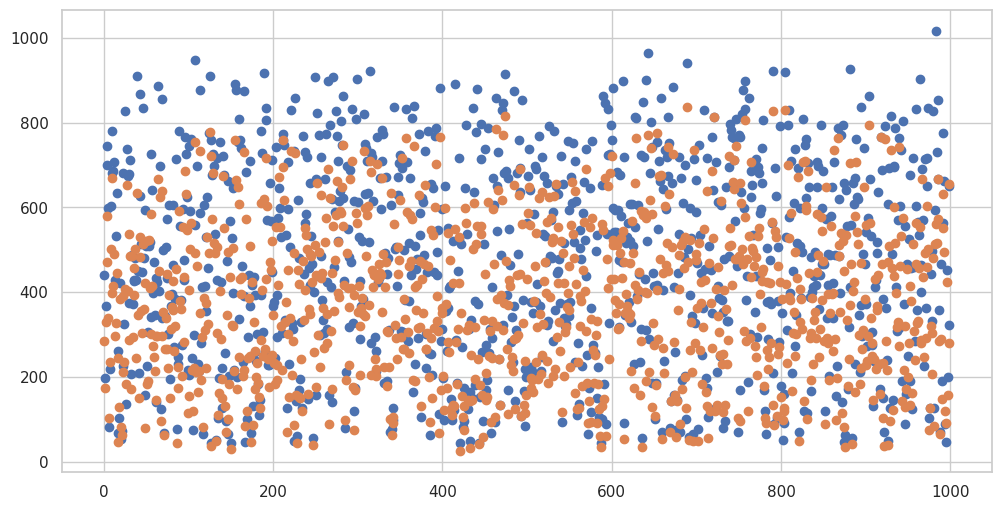

In [42]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(df['Final_Price'], "o", label="Final Price")
plt.plot(df['Historical_Cost_of_Ride'], "o", label="Historical Cost of Ride")
plt.show()

In [43]:
base_processed_df = data_one_hot.copy()
# Generate a synthetic regression dataset
X = data_one_hot.drop('Historical_Cost_of_Ride', axis=1)  # Exclude the target variable
y_original = data_one_hot['Historical_Cost_of_Ride']
print(X.columns)
y = df['Final_Price']

# Split data into training and test sets
X_train, X_test, y_train, y_test, y_train_original, y_test_original = train_test_split(X, y, y_original,  test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
#"OrthogonalMatchingPursuit": (OrthogonalMatchingPursuit(fit_intercept=False), {"n_nonzero_coefs": [5, 6, 7, 8, 9, 10, 15]}),
# Define models and their hyperparameter grids
models_and_params = {
    "LinearRegression": (LinearRegression(fit_intercept=False), {}),
    "HuberRegressor": (HuberRegressor(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "epsilon": [1.35, 1.5, 1.75]}),
    "SGDRegressor": (SGDRegressor(fit_intercept=False, penalty=None, max_iter=1000, tol=1e-3),
                      {"alpha": np.logspace(-4, -1, 4), "learning_rate": ["constant", "optimal", "invscaling"], "eta0": [0.01, 0.1, 1.0]}),

    "Lasso": (Lasso(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4)}),
    "Ridge": (Ridge(fit_intercept=False), {"alpha": np.logspace(-2, 1, 5), "solver": ["auto", "svd", "cholesky"]}),
    "ElasticNet": (ElasticNet(fit_intercept=False), {"alpha": np.logspace(-3, 0, 4), "l1_ratio": [0.1, 0.5, 0.9]})
}

# Evaluate models
results = []
for name, (model, params) in models_and_params.items():
    try:
        # Perform grid search with cross-validation
        grid_search = GridSearchCV(model, params, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Get best model and its performance
        best_model = grid_search.best_estimator_
        best_score = -grid_search.best_score_  # Convert negative MSE to positive
        best_params = grid_search.best_params_

        # Test data evaluation
        y_test_pred = best_model.predict(X_test)
        test_mse = mean_squared_error(y_test, y_test_pred)
        test_r2 = r2_score(y_test, y_test_pred)

        # Fit the best model to retrieve coefficients
        best_model.fit(X_train, y_train)
        coefficients = best_model.coef_

        results.append({
            "Model": name,
            "Best_Params": best_params,
            "Mean_CV_MAE": best_score,
            "Test_MAE": test_mse,
            "Test_R2": test_r2,
            "Coefficients": coefficients
        })
    except Exception as e:
        print(f"Model {name} failed with error: {e}")


# Create a DataFrame to display results
results_df = pd.DataFrame(results)

# Sort by performance (Mean CV MSE)
results_df = results_df.sort_values(by="Test_MAE")

# Add coefficients to the results DataFrame
results_df["Coefficients"] = results_df["Coefficients"].apply(lambda coef: np.array2string(coef, precision=3, separator=","))

# Display results
print("Model Performance (Train and Test):")
print(results_df[["Model", "Mean_CV_MAE", "Test_MAE", "Test_R2"]])

# Display Coefficients of the Top Model
top_model_row = results_df.iloc[0]  # Get the best-performing model
print("\nTop Model Details:")
print(f"Model: {top_model_row['Model']}")
print(f"Mean CV MAE: {top_model_row['Mean_CV_MAE']}")
print(f"Test MAE: {top_model_row['Test_MAE']}")
print(f"Test R2: {top_model_row['Test_R2']}")
print(f"Best Params: {top_model_row['Best_Params']}")
print(f"Coefficients:\n{top_model_row['Coefficients']}")

# Generate the regression equation
intercept = best_params.get("intercept_", 0)  # Assuming intercept is stored in params
equation = f"{top_model_row['Model']} Equation:\n"
equation += "y = " + " + ".join([f"{coeff:.3f}*{name}" for coeff, name in zip(coefficients, X.columns)])
equation += f" + {intercept:.3f}"
print(f"Equation:\n{equation}")
# Save the results as CSV (optional)
#results_df.to_csv("model_results.csv", index=False)

Index(['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides',
       'Average_Ratings', 'Expected_Ride_Duration',
       'Location_Category_Suburban', 'Location_Category_Urban',
       'Customer_Loyalty_Status_Regular', 'Customer_Loyalty_Status_Silver',
       'Time_of_Booking_Evening', 'Time_of_Booking_Morning',
       'Time_of_Booking_Night', 'Vehicle_Type_Premium'],
      dtype='object')
Training set shape: (800, 13) (800,)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_huber.py:343: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Model Performance (Train and Test):
              Model   Mean_CV_MAE      Test_MAE       Test_R2
0  LinearRegression  1.316976e+01  3.488765e+02  9.942053e-01
3             Lasso  1.316982e+01  3.489165e+02  9.942046e-01
4             Ridge  1.316915e+01  3.492972e+02  9.941983e-01
5        ElasticNet  1.316910e+01  3.498605e+02  9.941890e-01
1    HuberRegressor  1.319175e+01  3.733470e+02  9.937989e-01
2      SGDRegressor  3.578120e+11  1.575528e+23 -2.616888e+18

Top Model Details:
Model: LinearRegression
Mean CV MAE: 13.169756460652147
Test MAE: 348.8765348107014
Test R2: 0.9942053014680663
Best Params: {}
Coefficients:
[-2.938e-02, 2.642e-02,-4.918e-02,-5.951e+00, 4.745e+00,-1.027e+01,
 -2.898e+01, 5.605e+01, 2.042e+01, 9.329e+00,-1.089e+01, 3.773e+01,
  1.930e+01]
Equation:
LinearRegression Equation:
y = -0.029*Number_of_Riders + 0.026*Number_of_Drivers + -0.049*Number_of_Past_Rides + -5.896*Average_Ratings + 4.745*Expected_Ride_Duration + -10.111*Location_Category_Suburban + -28

In [44]:
# Extract the best model details from the sorted results DataFrame
top_model_name = results_df.iloc[0]["Model"]
top_model_params = results_df.iloc[0]["Best_Params"]
top_model_coefficients = np.fromstring(results_df.iloc[0]["Coefficients"].strip("[]"), sep=",")
print(f"Best Model: {top_model_name}")
print(f"Best Params: {top_model_params}")
print(f"Coefficients: {top_model_coefficients}")

# Reinitialize and train the best model
best_model_class, best_model_param_grid = models_and_params[top_model_name]
best_model = best_model_class.set_params(**top_model_params)
best_model.fit(X_train, y_train)

y_pred_test = best_model.predict(X_test)

Best Model: LinearRegression
Best Params: {}
Coefficients: [-2.938e-02  2.642e-02 -4.918e-02 -5.951e+00  4.745e+00 -1.027e+01
 -2.898e+01  5.605e+01  2.042e+01  9.329e+00 -1.089e+01  3.773e+01
  1.930e+01]


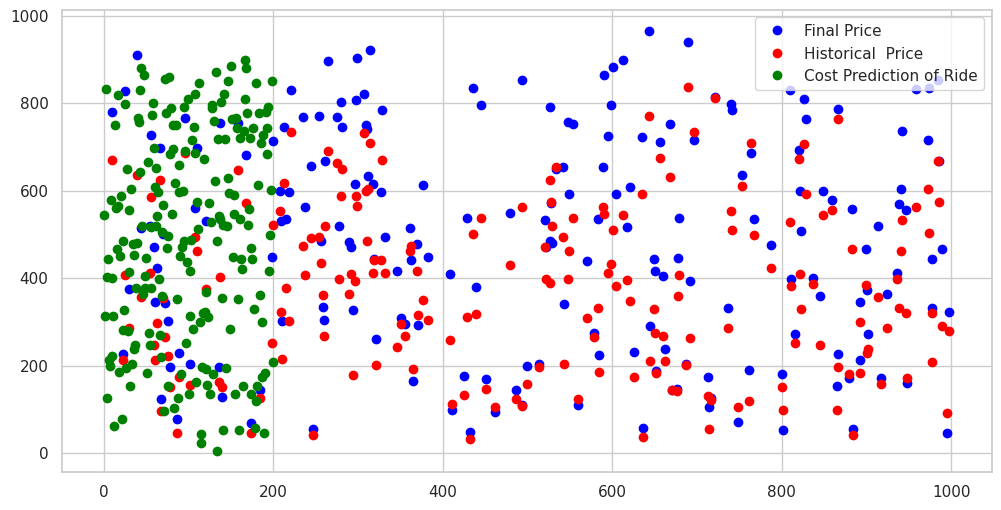

X_test.shape (200, 13)
y_test.shape (200,)
y_pred_test.shape (200,)
y_test_original.shape (200,)


In [45]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test, "o", label="Final Price", color='blue')
plt.plot(y_test_original, "o", label="Historical  Price", color='red')
plt.plot(y_pred_test, "o", label="Cost Prediction of Ride", color='green')
plt.legend()
plt.show()
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)
print("y_pred_test.shape", y_pred_test.shape)
print("y_test_original.shape", y_test_original.shape)


In [46]:
# # Scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(base_processed_df['Number_of_Riders'], base_processed_df['Number_of_Drivers'], color='blue', alpha=0.7, edgecolors='black')

# # Adding titles and labels
# plt.title('Scatter Plot: Number of Riders vs Number of Drivers', fontsize=16)
# plt.xlabel('Number of Riders', fontsize=12)
# plt.ylabel('Number of Drivers', fontsize=12)
# plt.grid(True)
# plt.show()

In [47]:
# from sklearn.linear_model import HuberRegressor
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# import matplotlib.pyplot as plt

# # Using HuberRegressor with no intercept
# model_no_intercept = HuberRegressor(fit_intercept=False)
# model_no_intercept.fit(base_processed_df['Number_of_Riders'].values.reshape(-1, 1), base_processed_df['Number_of_Drivers'].values)

# # Get the equation parameters for no intercept
# slope_no_intercept = model_no_intercept.coef_[0]  # Slope of the line
# fitted_line_no_intercept = model_no_intercept.predict(base_processed_df['Number_of_Riders'].values.reshape(-1, 1))

# # Metrics for no intercept
# mse_no_intercept = mean_squared_error(base_processed_df['Number_of_Drivers'], fitted_line_no_intercept)
# r2_no_intercept = r2_score(base_processed_df['Number_of_Drivers'], fitted_line_no_intercept)
# mae_no_intercept = mean_absolute_error(base_processed_df['Number_of_Drivers'], fitted_line_no_intercept)

# # Using HuberRegressor with intercept
# model_with_intercept = HuberRegressor(fit_intercept=True)
# model_with_intercept.fit(base_processed_df['Number_of_Riders'].values.reshape(-1, 1), base_processed_df['Number_of_Drivers'].values)

# # Get the equation parameters for with intercept
# slope_with_intercept = model_with_intercept.coef_[0]  # Slope of the line
# intercept_with_intercept = model_with_intercept.intercept_  # Intercept of the line
# fitted_line_with_intercept = model_with_intercept.predict(base_processed_df['Number_of_Riders'].values.reshape(-1, 1))

# # Metrics for with intercept
# mse_with_intercept = mean_squared_error(base_processed_df['Number_of_Drivers'], fitted_line_with_intercept)
# r2_with_intercept = r2_score(base_processed_df['Number_of_Drivers'], fitted_line_with_intercept)
# mae_with_intercept = mean_absolute_error(base_processed_df['Number_of_Drivers'], fitted_line_with_intercept)

# # Plot with fitted lines
# plt.figure(figsize=(10, 6))
# plt.scatter(base_processed_df['Number_of_Riders'], base_processed_df['Number_of_Drivers'], color='blue', alpha=0.7, edgecolors='black', label='Data Points')
# plt.plot(base_processed_df['Number_of_Riders'], fitted_line_no_intercept, color='red', label=f'No Intercept: y = {slope_no_intercept:.2f}x')
# plt.plot(base_processed_df['Number_of_Riders'], fitted_line_with_intercept, color='green', linestyle='--', label=f'With Intercept: y = {slope_with_intercept:.2f}x + {intercept_with_intercept:.2f}')

# # Adding titles and labels
# plt.title('Scatter Plot with Fitted Lines: Riders vs Drivers (HuberRegressor)', fontsize=16)
# plt.xlabel('Number of Riders', fontsize=12)
# plt.ylabel('Number of Drivers', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.show()

# # Display the equations and metrics
# print(f"The fitted equation without intercept is: Number_of_Drivers = {slope_no_intercept:.3f} Number_of_Riders")
# print(f"Metrics for no intercept: MAE = {mse_no_intercept:.3f}, R2 = {r2_no_intercept:.3f}, MAE = {mae_no_intercept:.3f}\n")

# print(f"The fitted equation with intercept is: Number_of_Drivers = {intercept_with_intercept:.3f} + {slope_with_intercept:.3f} Number_of_Riders")
# print(f"Metrics for with intercept: MAE = {mse_with_intercept:.3f}, R2 = {r2_with_intercept:.3f}, MAE = {mae_with_intercept:.3f}")


In [48]:
# Base Fare=Fixed Rate+(Per-Minute Charge×Expected Duration)+(Per-Kilometer Charge×Distance)
